## 待解方程
$$
\left\{\begin{array}{rl}u_{t}(x, t) & =u_{x x}(x, t)-7 * \sin (2 \pi x) * u(x, t) \\ u(x, t) & =u(x+1, t), \\ u(x, 0) & =1\end{array} \quad x, t \in[0,1] .\right.
$$

## 定义价值函数

由方程构造函数
$$
\left\{\begin{array}{l}f:=u_{t}(x, t)-u_{x x}(x, t)+c * \sin (2 \pi x) * u(x, t) \\ g_1:=u(x, t)-u(x+1, t)  \\ g_2:=u(x, t)-u(x-1, t)  \\ h:=u(x, 0)-1\end{array}\right.
$$

价值函数
$$
\left\{\begin{array}{l}\text { loss }_{f}=\frac{1}{N_{f}} \sum_{i=1}^{N_{f}}\left|f\left(x_{f}^{i}, t_{f}^{i}\right)\right|^{2} \\ \operatorname{loss}_{g_1}=\frac{1}{N_{g}} \sum_{i=1}^{N_{g}}\left|g_1\left(x_{g}^{i}, t_{g}^{i}\right)\right|^{2} \\ 
\operatorname{loss}_{g_2}=\frac{1}{N_{g}} \sum_{i=1}^{N_{g}}\left|g_2\left(x_{g}^{i}, t_{g}^{i}\right)\right|^{2} \\ \operatorname{loss}_{h}=\frac{1}{N_{h}} \sum_{i=1}^{N_{h}}\left|h\left(x_{h}^{i}\right)\right|^{2}\end{array}\right.
$$

总的价值函数
$$
\text { loss }_{\text {total }}=\alpha * \operatorname{loss}_{f}+\beta_{1} * \operatorname{loss}_{g_1} +\beta_{2} * \operatorname{loss}_{g_1} +\beta_{3} * \operatorname{los} s_{h}
$$

参考: https://github.com/udemirezen/PINN-1 

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
import numpy as np
from numpy.linalg import inv

In [3]:
alf = 1.
beta1 = 50.
beta2 = 50.
beta3 = 50.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,21)
        self.hidden_layer2 = nn.Linear(21,21)
        self.hidden_layer3 = nn.Linear(21,21)
        self.hidden_layer4 = nn.Linear(21,21)
        self.hidden_layer5 = nn.Linear(21,21)
        self.output_layer = nn.Linear(21,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [5]:
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [6]:
def f(x,t, net):
    u = net(x,t) 
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    c = 7
    pde = u_t - u_xx + c*torch.sin(2*np.pi*x)*u 
    return pde

In [7]:
#init condition 
x_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
t_bc = np.zeros((500,1))
u_bc = np.ones((500,1))

x_periodic = np.random.uniform(low=0.0, high=1.0, size=(500,1))
x_periodic_plusone = x_periodic + 1
x_periodic_minusone = x_periodic - 1
t_periodic = np.random.uniform(low=0.0, high=1.0, size=(500,1))
zeros_periodic = np.zeros((500,1))

x_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
all_zeros = np.zeros((500,1))

In [8]:
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on periodic conditions
    pt_x_periodic = Variable(torch.from_numpy(x_periodic).float(), requires_grad=True).to(device)
    pt_x_periodic_plusone = Variable(torch.from_numpy(x_periodic_plusone).float(), requires_grad=True).to(device)
    pt_x_periodic_minusone = Variable(torch.from_numpy(x_periodic_minusone).float(), requires_grad=True).to(device)
    pt_t_periodic = Variable(torch.from_numpy(t_periodic).float(), requires_grad=True).to(device)

    
    net_periodiccondition_out = net(pt_x_periodic, pt_t_periodic)
    net_periodiccondition_out1 = net(pt_x_periodic_plusone, pt_t_periodic)
    net_periodiccondition_out2 = net(pt_x_periodic_minusone, pt_t_periodic)
    
    mse_pc1 = mse_cost_function(net_periodiccondition_out, net_periodiccondition_out1)
    mse_pc2 = mse_cost_function(net_periodiccondition_out, net_periodiccondition_out2)
    
    # Loss based on PDE
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = alf*mse_f + beta1*mse_u + beta2*mse_pc1+ beta3*mse_pc2
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
        print(epoch,"Traning Loss:",loss.data)
    

0 Traning Loss: tensor(206.6402)
1 Traning Loss: tensor(201.7672)
2 Traning Loss: tensor(196.9795)
3 Traning Loss: tensor(192.2777)
4 Traning Loss: tensor(187.6619)
5 Traning Loss: tensor(183.1318)
6 Traning Loss: tensor(178.6870)
7 Traning Loss: tensor(174.3268)
8 Traning Loss: tensor(170.0502)
9 Traning Loss: tensor(165.8563)
10 Traning Loss: tensor(161.7449)
11 Traning Loss: tensor(157.7150)
12 Traning Loss: tensor(153.7659)
13 Traning Loss: tensor(149.8971)
14 Traning Loss: tensor(146.1073)
15 Traning Loss: tensor(142.3958)
16 Traning Loss: tensor(138.7617)
17 Traning Loss: tensor(135.2043)
18 Traning Loss: tensor(131.7221)
19 Traning Loss: tensor(128.3145)
20 Traning Loss: tensor(124.9805)
21 Traning Loss: tensor(121.7191)
22 Traning Loss: tensor(118.5292)
23 Traning Loss: tensor(115.4096)
24 Traning Loss: tensor(112.3597)
25 Traning Loss: tensor(109.3782)
26 Traning Loss: tensor(106.4641)
27 Traning Loss: tensor(103.6163)
28 Traning Loss: tensor(100.8337)
29 Traning Loss: tensor(

252 Traning Loss: tensor(16.5437)
253 Traning Loss: tensor(16.5436)
254 Traning Loss: tensor(16.5435)
255 Traning Loss: tensor(16.5434)
256 Traning Loss: tensor(16.5434)
257 Traning Loss: tensor(16.5433)
258 Traning Loss: tensor(16.5432)
259 Traning Loss: tensor(16.5431)
260 Traning Loss: tensor(16.5431)
261 Traning Loss: tensor(16.5430)
262 Traning Loss: tensor(16.5429)
263 Traning Loss: tensor(16.5428)
264 Traning Loss: tensor(16.5428)
265 Traning Loss: tensor(16.5427)
266 Traning Loss: tensor(16.5426)
267 Traning Loss: tensor(16.5425)
268 Traning Loss: tensor(16.5425)
269 Traning Loss: tensor(16.5424)
270 Traning Loss: tensor(16.5423)
271 Traning Loss: tensor(16.5422)
272 Traning Loss: tensor(16.5422)
273 Traning Loss: tensor(16.5421)
274 Traning Loss: tensor(16.5420)
275 Traning Loss: tensor(16.5419)
276 Traning Loss: tensor(16.5419)
277 Traning Loss: tensor(16.5418)
278 Traning Loss: tensor(16.5417)
279 Traning Loss: tensor(16.5416)
280 Traning Loss: tensor(16.5415)
281 Traning Lo

495 Traning Loss: tensor(16.5187)
496 Traning Loss: tensor(16.5185)
497 Traning Loss: tensor(16.5184)
498 Traning Loss: tensor(16.5182)
499 Traning Loss: tensor(16.5181)
500 Traning Loss: tensor(16.5179)
501 Traning Loss: tensor(16.5177)
502 Traning Loss: tensor(16.5176)
503 Traning Loss: tensor(16.5174)
504 Traning Loss: tensor(16.5173)
505 Traning Loss: tensor(16.5171)
506 Traning Loss: tensor(16.5169)
507 Traning Loss: tensor(16.5168)
508 Traning Loss: tensor(16.5166)
509 Traning Loss: tensor(16.5164)
510 Traning Loss: tensor(16.5163)
511 Traning Loss: tensor(16.5161)
512 Traning Loss: tensor(16.5159)
513 Traning Loss: tensor(16.5158)
514 Traning Loss: tensor(16.5156)
515 Traning Loss: tensor(16.5154)
516 Traning Loss: tensor(16.5153)
517 Traning Loss: tensor(16.5151)
518 Traning Loss: tensor(16.5149)
519 Traning Loss: tensor(16.5147)
520 Traning Loss: tensor(16.5146)
521 Traning Loss: tensor(16.5144)
522 Traning Loss: tensor(16.5142)
523 Traning Loss: tensor(16.5140)
524 Traning Lo

745 Traning Loss: tensor(16.4105)
746 Traning Loss: tensor(16.4094)
747 Traning Loss: tensor(16.4082)
748 Traning Loss: tensor(16.4071)
749 Traning Loss: tensor(16.4059)
750 Traning Loss: tensor(16.4047)
751 Traning Loss: tensor(16.4035)
752 Traning Loss: tensor(16.4023)
753 Traning Loss: tensor(16.4011)
754 Traning Loss: tensor(16.3999)
755 Traning Loss: tensor(16.3986)
756 Traning Loss: tensor(16.3974)
757 Traning Loss: tensor(16.3961)
758 Traning Loss: tensor(16.3948)
759 Traning Loss: tensor(16.3935)
760 Traning Loss: tensor(16.3922)
761 Traning Loss: tensor(16.3908)
762 Traning Loss: tensor(16.3895)
763 Traning Loss: tensor(16.3881)
764 Traning Loss: tensor(16.3868)
765 Traning Loss: tensor(16.3854)
766 Traning Loss: tensor(16.3840)
767 Traning Loss: tensor(16.3825)
768 Traning Loss: tensor(16.3811)
769 Traning Loss: tensor(16.3796)
770 Traning Loss: tensor(16.3782)
771 Traning Loss: tensor(16.3767)
772 Traning Loss: tensor(16.3752)
773 Traning Loss: tensor(16.3737)
774 Traning Lo

991 Traning Loss: tensor(14.5249)
992 Traning Loss: tensor(14.4974)
993 Traning Loss: tensor(14.4694)
994 Traning Loss: tensor(14.4411)
995 Traning Loss: tensor(14.4124)
996 Traning Loss: tensor(14.3832)
997 Traning Loss: tensor(14.3536)
998 Traning Loss: tensor(14.3236)
999 Traning Loss: tensor(14.2931)
1000 Traning Loss: tensor(14.2622)
1001 Traning Loss: tensor(14.2309)
1002 Traning Loss: tensor(14.1992)
1003 Traning Loss: tensor(14.1670)
1004 Traning Loss: tensor(14.1343)
1005 Traning Loss: tensor(14.1012)
1006 Traning Loss: tensor(14.0677)
1007 Traning Loss: tensor(14.0337)
1008 Traning Loss: tensor(13.9993)
1009 Traning Loss: tensor(13.9644)
1010 Traning Loss: tensor(13.9291)
1011 Traning Loss: tensor(13.8933)
1012 Traning Loss: tensor(13.8571)
1013 Traning Loss: tensor(13.8204)
1014 Traning Loss: tensor(13.7832)
1015 Traning Loss: tensor(13.7457)
1016 Traning Loss: tensor(13.7076)
1017 Traning Loss: tensor(13.6691)
1018 Traning Loss: tensor(13.6302)
1019 Traning Loss: tensor(13.

1235 Traning Loss: tensor(4.4315)
1236 Traning Loss: tensor(4.4239)
1237 Traning Loss: tensor(4.4165)
1238 Traning Loss: tensor(4.4092)
1239 Traning Loss: tensor(4.4021)
1240 Traning Loss: tensor(4.3952)
1241 Traning Loss: tensor(4.3885)
1242 Traning Loss: tensor(4.3820)
1243 Traning Loss: tensor(4.3756)
1244 Traning Loss: tensor(4.3693)
1245 Traning Loss: tensor(4.3633)
1246 Traning Loss: tensor(4.3573)
1247 Traning Loss: tensor(4.3515)
1248 Traning Loss: tensor(4.3459)
1249 Traning Loss: tensor(4.3404)
1250 Traning Loss: tensor(4.3350)
1251 Traning Loss: tensor(4.3297)
1252 Traning Loss: tensor(4.3245)
1253 Traning Loss: tensor(4.3195)
1254 Traning Loss: tensor(4.3146)
1255 Traning Loss: tensor(4.3098)
1256 Traning Loss: tensor(4.3051)
1257 Traning Loss: tensor(4.3005)
1258 Traning Loss: tensor(4.2959)
1259 Traning Loss: tensor(4.2915)
1260 Traning Loss: tensor(4.2872)
1261 Traning Loss: tensor(4.2829)
1262 Traning Loss: tensor(4.2788)
1263 Traning Loss: tensor(4.2747)
1264 Traning L

1479 Traning Loss: tensor(3.9243)
1480 Traning Loss: tensor(3.9232)
1481 Traning Loss: tensor(3.9222)
1482 Traning Loss: tensor(3.9211)
1483 Traning Loss: tensor(3.9200)
1484 Traning Loss: tensor(3.9190)
1485 Traning Loss: tensor(3.9179)
1486 Traning Loss: tensor(3.9168)
1487 Traning Loss: tensor(3.9158)
1488 Traning Loss: tensor(3.9147)
1489 Traning Loss: tensor(3.9137)
1490 Traning Loss: tensor(3.9126)
1491 Traning Loss: tensor(3.9116)
1492 Traning Loss: tensor(3.9105)
1493 Traning Loss: tensor(3.9095)
1494 Traning Loss: tensor(3.9084)
1495 Traning Loss: tensor(3.9074)
1496 Traning Loss: tensor(3.9064)
1497 Traning Loss: tensor(3.9054)
1498 Traning Loss: tensor(3.9043)
1499 Traning Loss: tensor(3.9033)
1500 Traning Loss: tensor(3.9023)
1501 Traning Loss: tensor(3.9013)
1502 Traning Loss: tensor(3.9003)
1503 Traning Loss: tensor(3.8993)
1504 Traning Loss: tensor(3.8983)
1505 Traning Loss: tensor(3.8973)
1506 Traning Loss: tensor(3.8963)
1507 Traning Loss: tensor(3.8953)
1508 Traning L

1726 Traning Loss: tensor(3.7983)
1727 Traning Loss: tensor(3.7981)
1728 Traning Loss: tensor(3.7979)
1729 Traning Loss: tensor(3.7977)
1730 Traning Loss: tensor(3.7975)
1731 Traning Loss: tensor(3.7972)
1732 Traning Loss: tensor(3.7970)
1733 Traning Loss: tensor(3.7968)
1734 Traning Loss: tensor(3.7966)
1735 Traning Loss: tensor(3.7964)
1736 Traning Loss: tensor(3.7962)
1737 Traning Loss: tensor(3.7960)
1738 Traning Loss: tensor(3.7958)
1739 Traning Loss: tensor(3.7956)
1740 Traning Loss: tensor(3.7954)
1741 Traning Loss: tensor(3.7951)
1742 Traning Loss: tensor(3.7949)
1743 Traning Loss: tensor(3.7947)
1744 Traning Loss: tensor(3.7945)
1745 Traning Loss: tensor(3.7943)
1746 Traning Loss: tensor(3.7941)
1747 Traning Loss: tensor(3.7939)
1748 Traning Loss: tensor(3.7937)
1749 Traning Loss: tensor(3.7935)
1750 Traning Loss: tensor(3.7933)
1751 Traning Loss: tensor(3.7931)
1752 Traning Loss: tensor(3.7929)
1753 Traning Loss: tensor(3.7927)
1754 Traning Loss: tensor(3.7925)
1755 Traning L

1976 Traning Loss: tensor(3.7438)
1977 Traning Loss: tensor(3.7436)
1978 Traning Loss: tensor(3.7433)
1979 Traning Loss: tensor(3.7431)
1980 Traning Loss: tensor(3.7428)
1981 Traning Loss: tensor(3.7426)
1982 Traning Loss: tensor(3.7424)
1983 Traning Loss: tensor(3.7421)
1984 Traning Loss: tensor(3.7419)
1985 Traning Loss: tensor(3.7416)
1986 Traning Loss: tensor(3.7414)
1987 Traning Loss: tensor(3.7411)
1988 Traning Loss: tensor(3.7409)
1989 Traning Loss: tensor(3.7407)
1990 Traning Loss: tensor(3.7404)
1991 Traning Loss: tensor(3.7402)
1992 Traning Loss: tensor(3.7399)
1993 Traning Loss: tensor(3.7397)
1994 Traning Loss: tensor(3.7395)
1995 Traning Loss: tensor(3.7392)
1996 Traning Loss: tensor(3.7390)
1997 Traning Loss: tensor(3.7387)
1998 Traning Loss: tensor(3.7385)
1999 Traning Loss: tensor(3.7382)
2000 Traning Loss: tensor(3.7380)
2001 Traning Loss: tensor(3.7378)
2002 Traning Loss: tensor(3.7375)
2003 Traning Loss: tensor(3.7373)
2004 Traning Loss: tensor(3.7370)
2005 Traning L

2222 Traning Loss: tensor(3.6888)
2223 Traning Loss: tensor(3.6886)
2224 Traning Loss: tensor(3.6884)
2225 Traning Loss: tensor(3.6883)
2226 Traning Loss: tensor(3.6881)
2227 Traning Loss: tensor(3.6879)
2228 Traning Loss: tensor(3.6877)
2229 Traning Loss: tensor(3.6875)
2230 Traning Loss: tensor(3.6874)
2231 Traning Loss: tensor(3.6872)
2232 Traning Loss: tensor(3.6870)
2233 Traning Loss: tensor(3.6868)
2234 Traning Loss: tensor(3.6867)
2235 Traning Loss: tensor(3.6865)
2236 Traning Loss: tensor(3.6863)
2237 Traning Loss: tensor(3.6862)
2238 Traning Loss: tensor(3.6860)
2239 Traning Loss: tensor(3.6858)
2240 Traning Loss: tensor(3.6856)
2241 Traning Loss: tensor(3.6855)
2242 Traning Loss: tensor(3.6853)
2243 Traning Loss: tensor(3.6851)
2244 Traning Loss: tensor(3.6850)
2245 Traning Loss: tensor(3.6848)
2246 Traning Loss: tensor(3.6846)
2247 Traning Loss: tensor(3.6845)
2248 Traning Loss: tensor(3.6843)
2249 Traning Loss: tensor(3.6841)
2250 Traning Loss: tensor(3.6840)
2251 Traning L

2467 Traning Loss: tensor(3.6552)
2468 Traning Loss: tensor(3.6551)
2469 Traning Loss: tensor(3.6550)
2470 Traning Loss: tensor(3.6549)
2471 Traning Loss: tensor(3.6548)
2472 Traning Loss: tensor(3.6546)
2473 Traning Loss: tensor(3.6545)
2474 Traning Loss: tensor(3.6544)
2475 Traning Loss: tensor(3.6543)
2476 Traning Loss: tensor(3.6542)
2477 Traning Loss: tensor(3.6540)
2478 Traning Loss: tensor(3.6539)
2479 Traning Loss: tensor(3.6538)
2480 Traning Loss: tensor(3.6537)
2481 Traning Loss: tensor(3.6536)
2482 Traning Loss: tensor(3.6534)
2483 Traning Loss: tensor(3.6533)
2484 Traning Loss: tensor(3.6532)
2485 Traning Loss: tensor(3.6531)
2486 Traning Loss: tensor(3.6529)
2487 Traning Loss: tensor(3.6528)
2488 Traning Loss: tensor(3.6527)
2489 Traning Loss: tensor(3.6526)
2490 Traning Loss: tensor(3.6525)
2491 Traning Loss: tensor(3.6523)
2492 Traning Loss: tensor(3.6522)
2493 Traning Loss: tensor(3.6521)
2494 Traning Loss: tensor(3.6520)
2495 Traning Loss: tensor(3.6518)
2496 Traning L

2716 Traning Loss: tensor(3.6066)
2717 Traning Loss: tensor(3.6062)
2718 Traning Loss: tensor(3.6058)
2719 Traning Loss: tensor(3.6054)
2720 Traning Loss: tensor(3.6051)
2721 Traning Loss: tensor(3.6047)
2722 Traning Loss: tensor(3.6043)
2723 Traning Loss: tensor(3.6039)
2724 Traning Loss: tensor(3.6035)
2725 Traning Loss: tensor(3.6031)
2726 Traning Loss: tensor(3.6027)
2727 Traning Loss: tensor(3.6023)
2728 Traning Loss: tensor(3.6019)
2729 Traning Loss: tensor(3.6014)
2730 Traning Loss: tensor(3.6010)
2731 Traning Loss: tensor(3.6006)
2732 Traning Loss: tensor(3.6002)
2733 Traning Loss: tensor(3.5998)
2734 Traning Loss: tensor(3.5993)
2735 Traning Loss: tensor(3.5989)
2736 Traning Loss: tensor(3.5985)
2737 Traning Loss: tensor(3.5980)
2738 Traning Loss: tensor(3.5976)
2739 Traning Loss: tensor(3.5971)
2740 Traning Loss: tensor(3.5967)
2741 Traning Loss: tensor(3.5962)
2742 Traning Loss: tensor(3.5958)
2743 Traning Loss: tensor(3.5953)
2744 Traning Loss: tensor(3.5949)
2745 Traning L

2962 Traning Loss: tensor(3.3155)
2963 Traning Loss: tensor(3.3124)
2964 Traning Loss: tensor(3.3094)
2965 Traning Loss: tensor(3.3062)
2966 Traning Loss: tensor(3.3031)
2967 Traning Loss: tensor(3.2999)
2968 Traning Loss: tensor(3.2967)
2969 Traning Loss: tensor(3.2934)
2970 Traning Loss: tensor(3.2901)
2971 Traning Loss: tensor(3.2867)
2972 Traning Loss: tensor(3.2833)
2973 Traning Loss: tensor(3.2799)
2974 Traning Loss: tensor(3.2764)
2975 Traning Loss: tensor(3.2729)
2976 Traning Loss: tensor(3.2694)
2977 Traning Loss: tensor(3.2658)
2978 Traning Loss: tensor(3.2621)
2979 Traning Loss: tensor(3.2584)
2980 Traning Loss: tensor(3.2547)
2981 Traning Loss: tensor(3.2509)
2982 Traning Loss: tensor(3.2471)
2983 Traning Loss: tensor(3.2432)
2984 Traning Loss: tensor(3.2393)
2985 Traning Loss: tensor(3.2353)
2986 Traning Loss: tensor(3.2313)
2987 Traning Loss: tensor(3.2273)
2988 Traning Loss: tensor(3.2231)
2989 Traning Loss: tensor(3.2190)
2990 Traning Loss: tensor(3.2147)
2991 Traning L

3204 Traning Loss: tensor(1.7220)
3205 Traning Loss: tensor(1.7199)
3206 Traning Loss: tensor(1.7179)
3207 Traning Loss: tensor(1.7159)
3208 Traning Loss: tensor(1.7140)
3209 Traning Loss: tensor(1.7121)
3210 Traning Loss: tensor(1.7102)
3211 Traning Loss: tensor(1.7084)
3212 Traning Loss: tensor(1.7066)
3213 Traning Loss: tensor(1.7049)
3214 Traning Loss: tensor(1.7032)
3215 Traning Loss: tensor(1.7015)
3216 Traning Loss: tensor(1.6999)
3217 Traning Loss: tensor(1.6983)
3218 Traning Loss: tensor(1.6968)
3219 Traning Loss: tensor(1.6952)
3220 Traning Loss: tensor(1.6937)
3221 Traning Loss: tensor(1.6923)
3222 Traning Loss: tensor(1.6908)
3223 Traning Loss: tensor(1.6894)
3224 Traning Loss: tensor(1.6880)
3225 Traning Loss: tensor(1.6866)
3226 Traning Loss: tensor(1.6853)
3227 Traning Loss: tensor(1.6840)
3228 Traning Loss: tensor(1.6826)
3229 Traning Loss: tensor(1.6814)
3230 Traning Loss: tensor(1.6801)
3231 Traning Loss: tensor(1.6788)
3232 Traning Loss: tensor(1.6776)
3233 Traning L

3447 Traning Loss: tensor(1.3660)
3448 Traning Loss: tensor(1.3648)
3449 Traning Loss: tensor(1.3635)
3450 Traning Loss: tensor(1.3623)
3451 Traning Loss: tensor(1.3611)
3452 Traning Loss: tensor(1.3598)
3453 Traning Loss: tensor(1.3586)
3454 Traning Loss: tensor(1.3574)
3455 Traning Loss: tensor(1.3562)
3456 Traning Loss: tensor(1.3550)
3457 Traning Loss: tensor(1.3538)
3458 Traning Loss: tensor(1.3526)
3459 Traning Loss: tensor(1.3514)
3460 Traning Loss: tensor(1.3503)
3461 Traning Loss: tensor(1.3491)
3462 Traning Loss: tensor(1.3479)
3463 Traning Loss: tensor(1.3468)
3464 Traning Loss: tensor(1.3456)
3465 Traning Loss: tensor(1.3445)
3466 Traning Loss: tensor(1.3433)
3467 Traning Loss: tensor(1.3422)
3468 Traning Loss: tensor(1.3411)
3469 Traning Loss: tensor(1.3399)
3470 Traning Loss: tensor(1.3388)
3471 Traning Loss: tensor(1.3377)
3472 Traning Loss: tensor(1.3366)
3473 Traning Loss: tensor(1.3355)
3474 Traning Loss: tensor(1.3344)
3475 Traning Loss: tensor(1.3333)
3476 Traning L

3689 Traning Loss: tensor(1.0849)
3690 Traning Loss: tensor(1.0833)
3691 Traning Loss: tensor(1.0817)
3692 Traning Loss: tensor(1.0801)
3693 Traning Loss: tensor(1.0785)
3694 Traning Loss: tensor(1.0769)
3695 Traning Loss: tensor(1.0753)
3696 Traning Loss: tensor(1.0737)
3697 Traning Loss: tensor(1.0721)
3698 Traning Loss: tensor(1.0705)
3699 Traning Loss: tensor(1.0689)
3700 Traning Loss: tensor(1.0672)
3701 Traning Loss: tensor(1.0656)
3702 Traning Loss: tensor(1.0640)
3703 Traning Loss: tensor(1.0624)
3704 Traning Loss: tensor(1.0608)
3705 Traning Loss: tensor(1.0592)
3706 Traning Loss: tensor(1.0576)
3707 Traning Loss: tensor(1.0559)
3708 Traning Loss: tensor(1.0543)
3709 Traning Loss: tensor(1.0527)
3710 Traning Loss: tensor(1.0511)
3711 Traning Loss: tensor(1.0495)
3712 Traning Loss: tensor(1.0479)
3713 Traning Loss: tensor(1.0463)
3714 Traning Loss: tensor(1.0447)
3715 Traning Loss: tensor(1.0431)
3716 Traning Loss: tensor(1.0415)
3717 Traning Loss: tensor(1.0399)
3718 Traning L

3931 Traning Loss: tensor(0.7681)
3932 Traning Loss: tensor(0.7672)
3933 Traning Loss: tensor(0.7663)
3934 Traning Loss: tensor(0.7654)
3935 Traning Loss: tensor(0.7645)
3936 Traning Loss: tensor(0.7637)
3937 Traning Loss: tensor(0.7628)
3938 Traning Loss: tensor(0.7619)
3939 Traning Loss: tensor(0.7610)
3940 Traning Loss: tensor(0.7601)
3941 Traning Loss: tensor(0.7593)
3942 Traning Loss: tensor(0.7584)
3943 Traning Loss: tensor(0.7575)
3944 Traning Loss: tensor(0.7566)
3945 Traning Loss: tensor(0.7558)
3946 Traning Loss: tensor(0.7549)
3947 Traning Loss: tensor(0.7541)
3948 Traning Loss: tensor(0.7532)
3949 Traning Loss: tensor(0.7523)
3950 Traning Loss: tensor(0.7515)
3951 Traning Loss: tensor(0.7506)
3952 Traning Loss: tensor(0.7498)
3953 Traning Loss: tensor(0.7489)
3954 Traning Loss: tensor(0.7481)
3955 Traning Loss: tensor(0.7472)
3956 Traning Loss: tensor(0.7464)
3957 Traning Loss: tensor(0.7455)
3958 Traning Loss: tensor(0.7447)
3959 Traning Loss: tensor(0.7438)
3960 Traning L

4176 Traning Loss: tensor(0.5998)
4177 Traning Loss: tensor(0.5993)
4178 Traning Loss: tensor(0.5989)
4179 Traning Loss: tensor(0.5985)
4180 Traning Loss: tensor(0.5980)
4181 Traning Loss: tensor(0.5976)
4182 Traning Loss: tensor(0.5972)
4183 Traning Loss: tensor(0.5967)
4184 Traning Loss: tensor(0.5963)
4185 Traning Loss: tensor(0.5959)
4186 Traning Loss: tensor(0.5954)
4187 Traning Loss: tensor(0.5950)
4188 Traning Loss: tensor(0.5946)
4189 Traning Loss: tensor(0.5942)
4190 Traning Loss: tensor(0.5937)
4191 Traning Loss: tensor(0.5933)
4192 Traning Loss: tensor(0.5929)
4193 Traning Loss: tensor(0.5925)
4194 Traning Loss: tensor(0.5921)
4195 Traning Loss: tensor(0.5917)
4196 Traning Loss: tensor(0.5912)
4197 Traning Loss: tensor(0.5908)
4198 Traning Loss: tensor(0.5904)
4199 Traning Loss: tensor(0.5900)
4200 Traning Loss: tensor(0.5896)
4201 Traning Loss: tensor(0.5892)
4202 Traning Loss: tensor(0.5888)
4203 Traning Loss: tensor(0.5884)
4204 Traning Loss: tensor(0.5880)
4205 Traning L

4423 Traning Loss: tensor(0.5190)
4424 Traning Loss: tensor(0.5188)
4425 Traning Loss: tensor(0.5186)
4426 Traning Loss: tensor(0.5184)
4427 Traning Loss: tensor(0.5181)
4428 Traning Loss: tensor(0.5179)
4429 Traning Loss: tensor(0.5177)
4430 Traning Loss: tensor(0.5174)
4431 Traning Loss: tensor(0.5172)
4432 Traning Loss: tensor(0.5170)
4433 Traning Loss: tensor(0.5167)
4434 Traning Loss: tensor(0.5165)
4435 Traning Loss: tensor(0.5163)
4436 Traning Loss: tensor(0.5161)
4437 Traning Loss: tensor(0.5158)
4438 Traning Loss: tensor(0.5156)
4439 Traning Loss: tensor(0.5154)
4440 Traning Loss: tensor(0.5152)
4441 Traning Loss: tensor(0.5149)
4442 Traning Loss: tensor(0.5147)
4443 Traning Loss: tensor(0.5145)
4444 Traning Loss: tensor(0.5143)
4445 Traning Loss: tensor(0.5141)
4446 Traning Loss: tensor(0.5138)
4447 Traning Loss: tensor(0.5136)
4448 Traning Loss: tensor(0.5134)
4449 Traning Loss: tensor(0.5132)
4450 Traning Loss: tensor(0.5130)
4451 Traning Loss: tensor(0.5127)
4452 Traning L

4665 Traning Loss: tensor(0.4730)
4666 Traning Loss: tensor(0.4729)
4667 Traning Loss: tensor(0.4727)
4668 Traning Loss: tensor(0.4725)
4669 Traning Loss: tensor(0.4724)
4670 Traning Loss: tensor(0.4722)
4671 Traning Loss: tensor(0.4721)
4672 Traning Loss: tensor(0.4719)
4673 Traning Loss: tensor(0.4717)
4674 Traning Loss: tensor(0.4716)
4675 Traning Loss: tensor(0.4714)
4676 Traning Loss: tensor(0.4713)
4677 Traning Loss: tensor(0.4711)
4678 Traning Loss: tensor(0.4710)
4679 Traning Loss: tensor(0.4708)
4680 Traning Loss: tensor(0.4706)
4681 Traning Loss: tensor(0.4705)
4682 Traning Loss: tensor(0.4703)
4683 Traning Loss: tensor(0.4702)
4684 Traning Loss: tensor(0.4700)
4685 Traning Loss: tensor(0.4699)
4686 Traning Loss: tensor(0.4697)
4687 Traning Loss: tensor(0.4695)
4688 Traning Loss: tensor(0.4694)
4689 Traning Loss: tensor(0.4692)
4690 Traning Loss: tensor(0.4691)
4691 Traning Loss: tensor(0.4689)
4692 Traning Loss: tensor(0.4688)
4693 Traning Loss: tensor(0.4686)
4694 Traning L

4907 Traning Loss: tensor(0.4378)
4908 Traning Loss: tensor(0.4377)
4909 Traning Loss: tensor(0.4375)
4910 Traning Loss: tensor(0.4374)
4911 Traning Loss: tensor(0.4372)
4912 Traning Loss: tensor(0.4371)
4913 Traning Loss: tensor(0.4370)
4914 Traning Loss: tensor(0.4368)
4915 Traning Loss: tensor(0.4367)
4916 Traning Loss: tensor(0.4366)
4917 Traning Loss: tensor(0.4364)
4918 Traning Loss: tensor(0.4363)
4919 Traning Loss: tensor(0.4361)
4920 Traning Loss: tensor(0.4360)
4921 Traning Loss: tensor(0.4359)
4922 Traning Loss: tensor(0.4357)
4923 Traning Loss: tensor(0.4356)
4924 Traning Loss: tensor(0.4354)
4925 Traning Loss: tensor(0.4353)
4926 Traning Loss: tensor(0.4352)
4927 Traning Loss: tensor(0.4350)
4928 Traning Loss: tensor(0.4349)
4929 Traning Loss: tensor(0.4347)
4930 Traning Loss: tensor(0.4346)
4931 Traning Loss: tensor(0.4345)
4932 Traning Loss: tensor(0.4343)
4933 Traning Loss: tensor(0.4342)
4934 Traning Loss: tensor(0.4340)
4935 Traning Loss: tensor(0.4339)
4936 Traning L

5149 Traning Loss: tensor(0.4018)
5150 Traning Loss: tensor(0.4016)
5151 Traning Loss: tensor(0.4015)
5152 Traning Loss: tensor(0.4013)
5153 Traning Loss: tensor(0.4011)
5154 Traning Loss: tensor(0.4009)
5155 Traning Loss: tensor(0.4008)
5156 Traning Loss: tensor(0.4006)
5157 Traning Loss: tensor(0.4004)
5158 Traning Loss: tensor(0.4002)
5159 Traning Loss: tensor(0.4001)
5160 Traning Loss: tensor(0.3999)
5161 Traning Loss: tensor(0.3997)
5162 Traning Loss: tensor(0.3996)
5163 Traning Loss: tensor(0.3994)
5164 Traning Loss: tensor(0.3993)
5165 Traning Loss: tensor(0.3993)
5166 Traning Loss: tensor(0.3992)
5167 Traning Loss: tensor(0.3990)
5168 Traning Loss: tensor(0.3988)
5169 Traning Loss: tensor(0.3984)
5170 Traning Loss: tensor(0.3981)
5171 Traning Loss: tensor(0.3980)
5172 Traning Loss: tensor(0.3979)
5173 Traning Loss: tensor(0.3977)
5174 Traning Loss: tensor(0.3975)
5175 Traning Loss: tensor(0.3972)
5176 Traning Loss: tensor(0.3970)
5177 Traning Loss: tensor(0.3969)
5178 Traning L

5392 Traning Loss: tensor(0.3379)
5393 Traning Loss: tensor(0.3376)
5394 Traning Loss: tensor(0.3373)
5395 Traning Loss: tensor(0.3369)
5396 Traning Loss: tensor(0.3366)
5397 Traning Loss: tensor(0.3363)
5398 Traning Loss: tensor(0.3360)
5399 Traning Loss: tensor(0.3357)
5400 Traning Loss: tensor(0.3354)
5401 Traning Loss: tensor(0.3350)
5402 Traning Loss: tensor(0.3347)
5403 Traning Loss: tensor(0.3344)
5404 Traning Loss: tensor(0.3341)
5405 Traning Loss: tensor(0.3338)
5406 Traning Loss: tensor(0.3335)
5407 Traning Loss: tensor(0.3331)
5408 Traning Loss: tensor(0.3328)
5409 Traning Loss: tensor(0.3325)
5410 Traning Loss: tensor(0.3322)
5411 Traning Loss: tensor(0.3319)
5412 Traning Loss: tensor(0.3316)
5413 Traning Loss: tensor(0.3313)
5414 Traning Loss: tensor(0.3310)
5415 Traning Loss: tensor(0.3307)
5416 Traning Loss: tensor(0.3305)
5417 Traning Loss: tensor(0.3304)
5418 Traning Loss: tensor(0.3305)
5419 Traning Loss: tensor(0.3304)
5420 Traning Loss: tensor(0.3300)
5421 Traning L

5641 Traning Loss: tensor(0.2661)
5642 Traning Loss: tensor(0.2657)
5643 Traning Loss: tensor(0.2655)
5644 Traning Loss: tensor(0.2653)
5645 Traning Loss: tensor(0.2650)
5646 Traning Loss: tensor(0.2647)
5647 Traning Loss: tensor(0.2644)
5648 Traning Loss: tensor(0.2641)
5649 Traning Loss: tensor(0.2639)
5650 Traning Loss: tensor(0.2637)
5651 Traning Loss: tensor(0.2634)
5652 Traning Loss: tensor(0.2631)
5653 Traning Loss: tensor(0.2628)
5654 Traning Loss: tensor(0.2626)
5655 Traning Loss: tensor(0.2624)
5656 Traning Loss: tensor(0.2621)
5657 Traning Loss: tensor(0.2618)
5658 Traning Loss: tensor(0.2615)
5659 Traning Loss: tensor(0.2613)
5660 Traning Loss: tensor(0.2611)
5661 Traning Loss: tensor(0.2608)
5662 Traning Loss: tensor(0.2605)
5663 Traning Loss: tensor(0.2603)
5664 Traning Loss: tensor(0.2600)
5665 Traning Loss: tensor(0.2598)
5666 Traning Loss: tensor(0.2595)
5667 Traning Loss: tensor(0.2593)
5668 Traning Loss: tensor(0.2590)
5669 Traning Loss: tensor(0.2587)
5670 Traning L

5884 Traning Loss: tensor(0.2098)
5885 Traning Loss: tensor(0.2096)
5886 Traning Loss: tensor(0.2094)
5887 Traning Loss: tensor(0.2092)
5888 Traning Loss: tensor(0.2090)
5889 Traning Loss: tensor(0.2088)
5890 Traning Loss: tensor(0.2086)
5891 Traning Loss: tensor(0.2084)
5892 Traning Loss: tensor(0.2082)
5893 Traning Loss: tensor(0.2080)
5894 Traning Loss: tensor(0.2078)
5895 Traning Loss: tensor(0.2076)
5896 Traning Loss: tensor(0.2074)
5897 Traning Loss: tensor(0.2072)
5898 Traning Loss: tensor(0.2071)
5899 Traning Loss: tensor(0.2069)
5900 Traning Loss: tensor(0.2067)
5901 Traning Loss: tensor(0.2065)
5902 Traning Loss: tensor(0.2063)
5903 Traning Loss: tensor(0.2061)
5904 Traning Loss: tensor(0.2059)
5905 Traning Loss: tensor(0.2057)
5906 Traning Loss: tensor(0.2055)
5907 Traning Loss: tensor(0.2053)
5908 Traning Loss: tensor(0.2051)
5909 Traning Loss: tensor(0.2050)
5910 Traning Loss: tensor(0.2048)
5911 Traning Loss: tensor(0.2046)
5912 Traning Loss: tensor(0.2044)
5913 Traning L

6127 Traning Loss: tensor(0.1737)
6128 Traning Loss: tensor(0.1736)
6129 Traning Loss: tensor(0.1735)
6130 Traning Loss: tensor(0.1734)
6131 Traning Loss: tensor(0.1733)
6132 Traning Loss: tensor(0.1732)
6133 Traning Loss: tensor(0.1731)
6134 Traning Loss: tensor(0.1730)
6135 Traning Loss: tensor(0.1729)
6136 Traning Loss: tensor(0.1728)
6137 Traning Loss: tensor(0.1726)
6138 Traning Loss: tensor(0.1725)
6139 Traning Loss: tensor(0.1724)
6140 Traning Loss: tensor(0.1723)
6141 Traning Loss: tensor(0.1722)
6142 Traning Loss: tensor(0.1721)
6143 Traning Loss: tensor(0.1720)
6144 Traning Loss: tensor(0.1719)
6145 Traning Loss: tensor(0.1718)
6146 Traning Loss: tensor(0.1717)
6147 Traning Loss: tensor(0.1716)
6148 Traning Loss: tensor(0.1715)
6149 Traning Loss: tensor(0.1714)
6150 Traning Loss: tensor(0.1713)
6151 Traning Loss: tensor(0.1712)
6152 Traning Loss: tensor(0.1711)
6153 Traning Loss: tensor(0.1710)
6154 Traning Loss: tensor(0.1709)
6155 Traning Loss: tensor(0.1708)
6156 Traning L

6373 Traning Loss: tensor(0.1549)
6374 Traning Loss: tensor(0.1548)
6375 Traning Loss: tensor(0.1548)
6376 Traning Loss: tensor(0.1547)
6377 Traning Loss: tensor(0.1547)
6378 Traning Loss: tensor(0.1546)
6379 Traning Loss: tensor(0.1546)
6380 Traning Loss: tensor(0.1545)
6381 Traning Loss: tensor(0.1544)
6382 Traning Loss: tensor(0.1544)
6383 Traning Loss: tensor(0.1543)
6384 Traning Loss: tensor(0.1543)
6385 Traning Loss: tensor(0.1542)
6386 Traning Loss: tensor(0.1541)
6387 Traning Loss: tensor(0.1541)
6388 Traning Loss: tensor(0.1540)
6389 Traning Loss: tensor(0.1540)
6390 Traning Loss: tensor(0.1539)
6391 Traning Loss: tensor(0.1539)
6392 Traning Loss: tensor(0.1539)
6393 Traning Loss: tensor(0.1539)
6394 Traning Loss: tensor(0.1540)
6395 Traning Loss: tensor(0.1543)
6396 Traning Loss: tensor(0.1547)
6397 Traning Loss: tensor(0.1555)
6398 Traning Loss: tensor(0.1564)
6399 Traning Loss: tensor(0.1571)
6400 Traning Loss: tensor(0.1568)
6401 Traning Loss: tensor(0.1553)
6402 Traning L

6615 Traning Loss: tensor(0.1434)
6616 Traning Loss: tensor(0.1430)
6617 Traning Loss: tensor(0.1436)
6618 Traning Loss: tensor(0.1443)
6619 Traning Loss: tensor(0.1443)
6620 Traning Loss: tensor(0.1435)
6621 Traning Loss: tensor(0.1429)
6622 Traning Loss: tensor(0.1429)
6623 Traning Loss: tensor(0.1433)
6624 Traning Loss: tensor(0.1435)
6625 Traning Loss: tensor(0.1431)
6626 Traning Loss: tensor(0.1427)
6627 Traning Loss: tensor(0.1426)
6628 Traning Loss: tensor(0.1428)
6629 Traning Loss: tensor(0.1429)
6630 Traning Loss: tensor(0.1427)
6631 Traning Loss: tensor(0.1424)
6632 Traning Loss: tensor(0.1423)
6633 Traning Loss: tensor(0.1424)
6634 Traning Loss: tensor(0.1425)
6635 Traning Loss: tensor(0.1424)
6636 Traning Loss: tensor(0.1422)
6637 Traning Loss: tensor(0.1421)
6638 Traning Loss: tensor(0.1422)
6639 Traning Loss: tensor(0.1422)
6640 Traning Loss: tensor(0.1421)
6641 Traning Loss: tensor(0.1420)
6642 Traning Loss: tensor(0.1419)
6643 Traning Loss: tensor(0.1419)
6644 Traning L

6859 Traning Loss: tensor(0.1333)
6860 Traning Loss: tensor(0.1333)
6861 Traning Loss: tensor(0.1332)
6862 Traning Loss: tensor(0.1332)
6863 Traning Loss: tensor(0.1331)
6864 Traning Loss: tensor(0.1331)
6865 Traning Loss: tensor(0.1331)
6866 Traning Loss: tensor(0.1330)
6867 Traning Loss: tensor(0.1330)
6868 Traning Loss: tensor(0.1330)
6869 Traning Loss: tensor(0.1329)
6870 Traning Loss: tensor(0.1329)
6871 Traning Loss: tensor(0.1328)
6872 Traning Loss: tensor(0.1328)
6873 Traning Loss: tensor(0.1328)
6874 Traning Loss: tensor(0.1327)
6875 Traning Loss: tensor(0.1327)
6876 Traning Loss: tensor(0.1326)
6877 Traning Loss: tensor(0.1326)
6878 Traning Loss: tensor(0.1326)
6879 Traning Loss: tensor(0.1325)
6880 Traning Loss: tensor(0.1325)
6881 Traning Loss: tensor(0.1325)
6882 Traning Loss: tensor(0.1324)
6883 Traning Loss: tensor(0.1324)
6884 Traning Loss: tensor(0.1323)
6885 Traning Loss: tensor(0.1323)
6886 Traning Loss: tensor(0.1323)
6887 Traning Loss: tensor(0.1322)
6888 Traning L

7105 Traning Loss: tensor(0.1242)
7106 Traning Loss: tensor(0.1241)
7107 Traning Loss: tensor(0.1241)
7108 Traning Loss: tensor(0.1241)
7109 Traning Loss: tensor(0.1240)
7110 Traning Loss: tensor(0.1240)
7111 Traning Loss: tensor(0.1239)
7112 Traning Loss: tensor(0.1239)
7113 Traning Loss: tensor(0.1239)
7114 Traning Loss: tensor(0.1238)
7115 Traning Loss: tensor(0.1238)
7116 Traning Loss: tensor(0.1238)
7117 Traning Loss: tensor(0.1237)
7118 Traning Loss: tensor(0.1237)
7119 Traning Loss: tensor(0.1236)
7120 Traning Loss: tensor(0.1236)
7121 Traning Loss: tensor(0.1236)
7122 Traning Loss: tensor(0.1235)
7123 Traning Loss: tensor(0.1235)
7124 Traning Loss: tensor(0.1235)
7125 Traning Loss: tensor(0.1234)
7126 Traning Loss: tensor(0.1234)
7127 Traning Loss: tensor(0.1233)
7128 Traning Loss: tensor(0.1233)
7129 Traning Loss: tensor(0.1233)
7130 Traning Loss: tensor(0.1232)
7131 Traning Loss: tensor(0.1232)
7132 Traning Loss: tensor(0.1232)
7133 Traning Loss: tensor(0.1231)
7134 Traning L

7351 Traning Loss: tensor(0.1151)
7352 Traning Loss: tensor(0.1151)
7353 Traning Loss: tensor(0.1151)
7354 Traning Loss: tensor(0.1150)
7355 Traning Loss: tensor(0.1150)
7356 Traning Loss: tensor(0.1150)
7357 Traning Loss: tensor(0.1149)
7358 Traning Loss: tensor(0.1149)
7359 Traning Loss: tensor(0.1148)
7360 Traning Loss: tensor(0.1148)
7361 Traning Loss: tensor(0.1148)
7362 Traning Loss: tensor(0.1147)
7363 Traning Loss: tensor(0.1147)
7364 Traning Loss: tensor(0.1147)
7365 Traning Loss: tensor(0.1146)
7366 Traning Loss: tensor(0.1146)
7367 Traning Loss: tensor(0.1145)
7368 Traning Loss: tensor(0.1145)
7369 Traning Loss: tensor(0.1145)
7370 Traning Loss: tensor(0.1144)
7371 Traning Loss: tensor(0.1144)
7372 Traning Loss: tensor(0.1144)
7373 Traning Loss: tensor(0.1143)
7374 Traning Loss: tensor(0.1143)
7375 Traning Loss: tensor(0.1143)
7376 Traning Loss: tensor(0.1142)
7377 Traning Loss: tensor(0.1142)
7378 Traning Loss: tensor(0.1141)
7379 Traning Loss: tensor(0.1141)
7380 Traning L

7595 Traning Loss: tensor(0.1066)
7596 Traning Loss: tensor(0.1066)
7597 Traning Loss: tensor(0.1064)
7598 Traning Loss: tensor(0.1062)
7599 Traning Loss: tensor(0.1062)
7600 Traning Loss: tensor(0.1063)
7601 Traning Loss: tensor(0.1063)
7602 Traning Loss: tensor(0.1062)
7603 Traning Loss: tensor(0.1061)
7604 Traning Loss: tensor(0.1060)
7605 Traning Loss: tensor(0.1060)
7606 Traning Loss: tensor(0.1060)
7607 Traning Loss: tensor(0.1060)
7608 Traning Loss: tensor(0.1059)
7609 Traning Loss: tensor(0.1059)
7610 Traning Loss: tensor(0.1058)
7611 Traning Loss: tensor(0.1058)
7612 Traning Loss: tensor(0.1058)
7613 Traning Loss: tensor(0.1058)
7614 Traning Loss: tensor(0.1057)
7615 Traning Loss: tensor(0.1057)
7616 Traning Loss: tensor(0.1056)
7617 Traning Loss: tensor(0.1056)
7618 Traning Loss: tensor(0.1056)
7619 Traning Loss: tensor(0.1055)
7620 Traning Loss: tensor(0.1055)
7621 Traning Loss: tensor(0.1054)
7622 Traning Loss: tensor(0.1054)
7623 Traning Loss: tensor(0.1054)
7624 Traning L

7843 Traning Loss: tensor(0.0978)
7844 Traning Loss: tensor(0.0977)
7845 Traning Loss: tensor(0.0977)
7846 Traning Loss: tensor(0.0977)
7847 Traning Loss: tensor(0.0976)
7848 Traning Loss: tensor(0.0976)
7849 Traning Loss: tensor(0.0976)
7850 Traning Loss: tensor(0.0975)
7851 Traning Loss: tensor(0.0975)
7852 Traning Loss: tensor(0.0975)
7853 Traning Loss: tensor(0.0974)
7854 Traning Loss: tensor(0.0974)
7855 Traning Loss: tensor(0.0974)
7856 Traning Loss: tensor(0.0973)
7857 Traning Loss: tensor(0.0973)
7858 Traning Loss: tensor(0.0973)
7859 Traning Loss: tensor(0.0972)
7860 Traning Loss: tensor(0.0972)
7861 Traning Loss: tensor(0.0972)
7862 Traning Loss: tensor(0.0971)
7863 Traning Loss: tensor(0.0971)
7864 Traning Loss: tensor(0.0971)
7865 Traning Loss: tensor(0.0970)
7866 Traning Loss: tensor(0.0970)
7867 Traning Loss: tensor(0.0970)
7868 Traning Loss: tensor(0.0969)
7869 Traning Loss: tensor(0.0969)
7870 Traning Loss: tensor(0.0969)
7871 Traning Loss: tensor(0.0968)
7872 Traning L

8090 Traning Loss: tensor(0.0897)
8091 Traning Loss: tensor(0.0897)
8092 Traning Loss: tensor(0.0897)
8093 Traning Loss: tensor(0.0897)
8094 Traning Loss: tensor(0.0896)
8095 Traning Loss: tensor(0.0895)
8096 Traning Loss: tensor(0.0895)
8097 Traning Loss: tensor(0.0895)
8098 Traning Loss: tensor(0.0895)
8099 Traning Loss: tensor(0.0894)
8100 Traning Loss: tensor(0.0894)
8101 Traning Loss: tensor(0.0893)
8102 Traning Loss: tensor(0.0893)
8103 Traning Loss: tensor(0.0893)
8104 Traning Loss: tensor(0.0892)
8105 Traning Loss: tensor(0.0892)
8106 Traning Loss: tensor(0.0892)
8107 Traning Loss: tensor(0.0891)
8108 Traning Loss: tensor(0.0891)
8109 Traning Loss: tensor(0.0891)
8110 Traning Loss: tensor(0.0890)
8111 Traning Loss: tensor(0.0890)
8112 Traning Loss: tensor(0.0890)
8113 Traning Loss: tensor(0.0889)
8114 Traning Loss: tensor(0.0889)
8115 Traning Loss: tensor(0.0889)
8116 Traning Loss: tensor(0.0889)
8117 Traning Loss: tensor(0.0888)
8118 Traning Loss: tensor(0.0888)
8119 Traning L

8338 Traning Loss: tensor(0.0843)
8339 Traning Loss: tensor(0.0848)
8340 Traning Loss: tensor(0.0852)
8341 Traning Loss: tensor(0.0851)
8342 Traning Loss: tensor(0.0844)
8343 Traning Loss: tensor(0.0833)
8344 Traning Loss: tensor(0.0823)
8345 Traning Loss: tensor(0.0818)
8346 Traning Loss: tensor(0.0819)
8347 Traning Loss: tensor(0.0824)
8348 Traning Loss: tensor(0.0828)
8349 Traning Loss: tensor(0.0829)
8350 Traning Loss: tensor(0.0825)
8351 Traning Loss: tensor(0.0820)
8352 Traning Loss: tensor(0.0816)
8353 Traning Loss: tensor(0.0815)
8354 Traning Loss: tensor(0.0818)
8355 Traning Loss: tensor(0.0820)
8356 Traning Loss: tensor(0.0820)
8357 Traning Loss: tensor(0.0818)
8358 Traning Loss: tensor(0.0815)
8359 Traning Loss: tensor(0.0814)
8360 Traning Loss: tensor(0.0813)
8361 Traning Loss: tensor(0.0814)
8362 Traning Loss: tensor(0.0815)
8363 Traning Loss: tensor(0.0815)
8364 Traning Loss: tensor(0.0814)
8365 Traning Loss: tensor(0.0812)
8366 Traning Loss: tensor(0.0811)
8367 Traning L

8584 Traning Loss: tensor(0.0748)
8585 Traning Loss: tensor(0.0748)
8586 Traning Loss: tensor(0.0747)
8587 Traning Loss: tensor(0.0747)
8588 Traning Loss: tensor(0.0747)
8589 Traning Loss: tensor(0.0746)
8590 Traning Loss: tensor(0.0746)
8591 Traning Loss: tensor(0.0746)
8592 Traning Loss: tensor(0.0746)
8593 Traning Loss: tensor(0.0745)
8594 Traning Loss: tensor(0.0745)
8595 Traning Loss: tensor(0.0745)
8596 Traning Loss: tensor(0.0744)
8597 Traning Loss: tensor(0.0744)
8598 Traning Loss: tensor(0.0744)
8599 Traning Loss: tensor(0.0744)
8600 Traning Loss: tensor(0.0743)
8601 Traning Loss: tensor(0.0743)
8602 Traning Loss: tensor(0.0743)
8603 Traning Loss: tensor(0.0742)
8604 Traning Loss: tensor(0.0742)
8605 Traning Loss: tensor(0.0742)
8606 Traning Loss: tensor(0.0742)
8607 Traning Loss: tensor(0.0741)
8608 Traning Loss: tensor(0.0741)
8609 Traning Loss: tensor(0.0741)
8610 Traning Loss: tensor(0.0740)
8611 Traning Loss: tensor(0.0740)
8612 Traning Loss: tensor(0.0740)
8613 Traning L

8829 Traning Loss: tensor(0.0680)
8830 Traning Loss: tensor(0.0680)
8831 Traning Loss: tensor(0.0679)
8832 Traning Loss: tensor(0.0679)
8833 Traning Loss: tensor(0.0679)
8834 Traning Loss: tensor(0.0679)
8835 Traning Loss: tensor(0.0678)
8836 Traning Loss: tensor(0.0678)
8837 Traning Loss: tensor(0.0678)
8838 Traning Loss: tensor(0.0678)
8839 Traning Loss: tensor(0.0677)
8840 Traning Loss: tensor(0.0677)
8841 Traning Loss: tensor(0.0677)
8842 Traning Loss: tensor(0.0676)
8843 Traning Loss: tensor(0.0676)
8844 Traning Loss: tensor(0.0676)
8845 Traning Loss: tensor(0.0676)
8846 Traning Loss: tensor(0.0675)
8847 Traning Loss: tensor(0.0675)
8848 Traning Loss: tensor(0.0675)
8849 Traning Loss: tensor(0.0674)
8850 Traning Loss: tensor(0.0674)
8851 Traning Loss: tensor(0.0674)
8852 Traning Loss: tensor(0.0674)
8853 Traning Loss: tensor(0.0673)
8854 Traning Loss: tensor(0.0673)
8855 Traning Loss: tensor(0.0673)
8856 Traning Loss: tensor(0.0673)
8857 Traning Loss: tensor(0.0672)
8858 Traning L

9077 Traning Loss: tensor(0.0615)
9078 Traning Loss: tensor(0.0615)
9079 Traning Loss: tensor(0.0614)
9080 Traning Loss: tensor(0.0614)
9081 Traning Loss: tensor(0.0614)
9082 Traning Loss: tensor(0.0613)
9083 Traning Loss: tensor(0.0613)
9084 Traning Loss: tensor(0.0613)
9085 Traning Loss: tensor(0.0613)
9086 Traning Loss: tensor(0.0612)
9087 Traning Loss: tensor(0.0612)
9088 Traning Loss: tensor(0.0612)
9089 Traning Loss: tensor(0.0612)
9090 Traning Loss: tensor(0.0612)
9091 Traning Loss: tensor(0.0611)
9092 Traning Loss: tensor(0.0611)
9093 Traning Loss: tensor(0.0611)
9094 Traning Loss: tensor(0.0611)
9095 Traning Loss: tensor(0.0611)
9096 Traning Loss: tensor(0.0611)
9097 Traning Loss: tensor(0.0611)
9098 Traning Loss: tensor(0.0611)
9099 Traning Loss: tensor(0.0612)
9100 Traning Loss: tensor(0.0613)
9101 Traning Loss: tensor(0.0615)
9102 Traning Loss: tensor(0.0617)
9103 Traning Loss: tensor(0.0620)
9104 Traning Loss: tensor(0.0624)
9105 Traning Loss: tensor(0.0630)
9106 Traning L

9327 Traning Loss: tensor(0.0569)
9328 Traning Loss: tensor(0.0570)
9329 Traning Loss: tensor(0.0566)
9330 Traning Loss: tensor(0.0559)
9331 Traning Loss: tensor(0.0554)
9332 Traning Loss: tensor(0.0554)
9333 Traning Loss: tensor(0.0556)
9334 Traning Loss: tensor(0.0559)
9335 Traning Loss: tensor(0.0560)
9336 Traning Loss: tensor(0.0559)
9337 Traning Loss: tensor(0.0555)
9338 Traning Loss: tensor(0.0553)
9339 Traning Loss: tensor(0.0552)
9340 Traning Loss: tensor(0.0553)
9341 Traning Loss: tensor(0.0554)
9342 Traning Loss: tensor(0.0555)
9343 Traning Loss: tensor(0.0554)
9344 Traning Loss: tensor(0.0553)
9345 Traning Loss: tensor(0.0551)
9346 Traning Loss: tensor(0.0550)
9347 Traning Loss: tensor(0.0550)
9348 Traning Loss: tensor(0.0551)
9349 Traning Loss: tensor(0.0551)
9350 Traning Loss: tensor(0.0551)
9351 Traning Loss: tensor(0.0550)
9352 Traning Loss: tensor(0.0549)
9353 Traning Loss: tensor(0.0549)
9354 Traning Loss: tensor(0.0549)
9355 Traning Loss: tensor(0.0549)
9356 Traning L

9577 Traning Loss: tensor(0.0503)
9578 Traning Loss: tensor(0.0502)
9579 Traning Loss: tensor(0.0502)
9580 Traning Loss: tensor(0.0503)
9581 Traning Loss: tensor(0.0502)
9582 Traning Loss: tensor(0.0502)
9583 Traning Loss: tensor(0.0501)
9584 Traning Loss: tensor(0.0501)
9585 Traning Loss: tensor(0.0501)
9586 Traning Loss: tensor(0.0501)
9587 Traning Loss: tensor(0.0501)
9588 Traning Loss: tensor(0.0500)
9589 Traning Loss: tensor(0.0500)
9590 Traning Loss: tensor(0.0500)
9591 Traning Loss: tensor(0.0500)
9592 Traning Loss: tensor(0.0500)
9593 Traning Loss: tensor(0.0499)
9594 Traning Loss: tensor(0.0499)
9595 Traning Loss: tensor(0.0499)
9596 Traning Loss: tensor(0.0499)
9597 Traning Loss: tensor(0.0498)
9598 Traning Loss: tensor(0.0498)
9599 Traning Loss: tensor(0.0498)
9600 Traning Loss: tensor(0.0498)
9601 Traning Loss: tensor(0.0498)
9602 Traning Loss: tensor(0.0497)
9603 Traning Loss: tensor(0.0497)
9604 Traning Loss: tensor(0.0497)
9605 Traning Loss: tensor(0.0497)
9606 Traning L

9819 Traning Loss: tensor(0.0459)
9820 Traning Loss: tensor(0.0458)
9821 Traning Loss: tensor(0.0458)
9822 Traning Loss: tensor(0.0459)
9823 Traning Loss: tensor(0.0459)
9824 Traning Loss: tensor(0.0459)
9825 Traning Loss: tensor(0.0458)
9826 Traning Loss: tensor(0.0458)
9827 Traning Loss: tensor(0.0458)
9828 Traning Loss: tensor(0.0459)
9829 Traning Loss: tensor(0.0460)
9830 Traning Loss: tensor(0.0460)
9831 Traning Loss: tensor(0.0461)
9832 Traning Loss: tensor(0.0463)
9833 Traning Loss: tensor(0.0466)
9834 Traning Loss: tensor(0.0470)
9835 Traning Loss: tensor(0.0475)
9836 Traning Loss: tensor(0.0481)
9837 Traning Loss: tensor(0.0488)
9838 Traning Loss: tensor(0.0493)
9839 Traning Loss: tensor(0.0495)
9840 Traning Loss: tensor(0.0491)
9841 Traning Loss: tensor(0.0482)
9842 Traning Loss: tensor(0.0469)
9843 Traning Loss: tensor(0.0459)
9844 Traning Loss: tensor(0.0454)
9845 Traning Loss: tensor(0.0456)
9846 Traning Loss: tensor(0.0461)
9847 Traning Loss: tensor(0.0466)
9848 Traning L

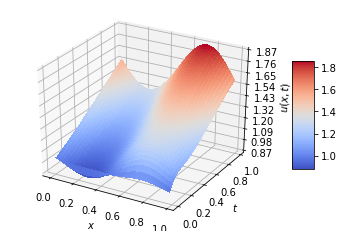

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x=np.arange(0,1,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)

## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(x,t)$')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()